In [1]:
#| default_exp tbats

# TBATS 

In [1]:
#| export
import math 
import os 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from numba import njit 
from numpy import linalg as LA 
from scipy.optimize import minimize_scalar, fmin
from scipy.stats import f
from time import time 

In [2]:
# Global variables 
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

## Load data 

In [3]:
# AirPassengers 
from statsforecast.utils import AirPassengers as ap 

# USAccDeaths
USAccDeaths = np.array([9007, 8106, 8928, 9137, 10017, 10826, 11317, 10744, 9713, 9938, 9161, 8927, 
                        7750, 6981, 8038, 8422, 8714, 9512, 10120, 9823, 8743, 9129, 8710, 8680, 
                        8162, 7306, 8124, 7870, 9387, 9556, 10093, 9620, 8285, 8466, 8160, 8034, 
                        7717, 7461, 7767, 7925, 8623, 8945, 10078, 9179, 8037, 8488, 7874, 8647, 
                        7792, 6957, 7726, 8106, 8890, 9299, 10625, 9302, 8314, 8850, 8265, 8796,
                        7836, 6892, 7791, 8192, 9115, 9434, 10484, 9827, 9110, 9070, 8633, 9240]) 

# Electricity consumption 
import pandas as pd 
elec_df = pd.read_csv('tbats.files/PJMW_hourly.csv')
elec = elec_df['PJMW_MW']
elec = elec[0:(24*7*2+1)]
elec = np.array(elec)

/Users/marianamenchero/Documents/statsforecast/statsforecast/core.py:24: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Box-Cox transformation

In [4]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def guer_cv(lam, x, season_length): 
    
    """
    Minimize this funtion to find the optimal parameter for the Box-Cox transformation.     
    """
    period = np.append(season_length, 2)
    period = np.round(np.max(period)) 
    n = len(x) 
    nyears = int(np.floor(n/period))
    nobs = np.floor(nyears*period)
    m = int(n-nobs)
    xmat = x[m:n].reshape((nyears, period))

    xmean = np.full(xmat.shape[0], fill_value = np.nan)
    for k in range(xmat.shape[0]): 
        xmean[k] = np.nanmean(xmat[k])

    xsd = np.full(xmat.shape[0], fill_value = np.nan)
    for k in range(xmat.shape[0]): 
        vals = xmat[k]
        svar = (vals-np.nanmean(vals))**2 
        svar = np.sum(svar)/(len(svar)-1) # sample variance 
        xsd[k] = np.sqrt(svar) # sample standard deviation 

    xrat = xsd/(xmean**(1-lam))

    sd = (xrat-np.nanmean(xrat))**2 # standard deviation 
    sd = np.nansum(sd)/(len(sd)-1)
    sd = np.sqrt(sd)
    
    return sd/np.nanmean(xrat)

In [5]:
def guerrero(x, season_length, lower=-1, upper=2): 
    
    """Finds optimal paramater for Box-Cox transformation using Guerrero's method"""
    
    if np.any(x < 0): 
        raise ValueError("Guerrero's method for selecting a Box-Cox parameter (lambda) is for strictly positive data")
    
    max_freq = np.max(season_length)
    if len(x) <= 2*max_freq: 
        res = np.array([1]) 
    else: 
        lam = 0 # initial guess 
        opt = minimize_scalar(guer_cv, lam, args = (x, season_length), method = 'bounded', bounds = (lower, upper))
        res = np.array([opt.x])
    
    return res

In [6]:
@njit(nogil=NOGIL, cache=CACHE)
def BoxCox(y, season_length, BoxCox_lambda): 
    
    """Applies Box-Cox transformation with parameter BoxCox_lambda"""
    
    if BoxCox_lambda == 0: 
        w = np.log(y)
    else: 
        w = np.sign(y)*((np.abs(y)**BoxCox_lambda)-1)
        w = w/BoxCox_lambda
        
    return w

In [7]:
@njit(nogil=NOGIL, cache=CACHE)
def InvBoxCox(w, season_length, BoxCox_lambda): 
    
    """Inverts Box-Cox transformation with parameter BoxCox_lambda"""
    
    if BoxCox_lambda == 0: 
        y = np.exp(w) 
    else: 
        sign = np.sign(BoxCox_lambda*w+1)
        y = np.abs(BoxCox_lambda*w+1)**(1/BoxCox_lambda)
        y = sign*y 
        
    return y 

In [8]:
@njit(nogil=NOGIL, cache=CACHE)
def findPQ(ar_coeffs, ma_coeffs): 
    """
    Find the length of the AR coefficients (p) 
    and the length of the MA coefficients (q) 
    """
    if ar_coeffs is not None: 
        p = len(ar_coeffs) 
    else: 
        p = 0 
    if ma_coeffs is not None: 
        q = len(ma_coeffs) 
    else: 
        q = 0 
    return p, q

## TBATS functions 

### createXVector

In [9]:
@njit(nogil=NOGIL, cache=CACHE)
def createXVector(b, s_vector, d_vector, epsilon_vector): 

    l = 0.0
    x = np.array([l])
    if b is not None: 
        x = np.append(x, b)
    if s_vector is not None: 
        x = np.concatenate((x, s_vector))
    if d_vector is not None: 
        x = np.concatenate((x, d_vector)) 
    if epsilon_vector is not None: 
        x = np.concatenate((x, epsilon_vector))
    
    return x 

### createWMatrixTBATS

In [10]:
@njit(nogil=NOGIL, cache=CACHE)
def createWMatrixTBATS(phi, k_vector, ar_coeffs, ma_coeffs, tau): 
    
    p, q = findPQ(ar_coeffs, ma_coeffs) 

    adjPhi = 0 
    numSeasonal = 0 
    numCols = 1

    if phi is not None: 
        adjPhi = 1 
        numCols = numCols+1
    if k_vector is not None: 
        numSeasonal = numSeasonal+len(k_vector) 
        numCols = numCols+tau 
    if ar_coeffs is not None: 
        numCols = numCols+p
    if ma_coeffs is not None: 
        numCols = numCols+q

    w_transpose = np.zeros((1, numCols))

    if k_vector is not None: 
        position = adjPhi 
        for s in range(0, numSeasonal):
            for j in range(position+1, position+k_vector[s]+1): 
                w_transpose[0,j] = 1 
            position = position+(2*k_vector[s])

    w_transpose[0,0] = 1

    if adjPhi == 1: 
        w_transpose[0,1] = phi

    if ar_coeffs is not None: 
        for i in range(1,p+1): 
            w_transpose[0,(adjPhi+tau+i)] = ar_coeffs[(i-1)]

    if ma_coeffs is not None: 
        for i in range(1,q+1): 
            w_transpose[0,(adjPhi+tau+p+i)] = ma_coeffs[(i-1)] 

    w = np.transpose(w_transpose) 

    return w_transpose, w 

### updateGammaBoldTBATS

In [11]:
@njit(nogil=NOGIL, cache=CACHE)
def updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v): 
    endPos = 0 
    numK = len(k_vector) 

    for i in range(numK): 
        for j in range(endPos, (k_vector[1]+endPos)): 
            gamma_bold[0,j] = gamma_one_v[i] 
        for k in range((k_vector[i]+endPos), (2*k_vector[i]+endPos)): 
            gamma_bold[0,k] = gamma_two_v[i]
        endPos = endPos + 2*k_vector[i] 

    return gamma_bold 

### updateGMatrixTBATS

In [12]:
@njit(nogil=NOGIL, cache=CACHE)
def updateGMatrixTBATS(g, gamma_bold, alpha, beta): 
    adjust_beta = 0 
    g[0,0] = alpha 
    if beta is not None: 
        g[1,0] = beta 
        adjust_beta = 1 
    if gamma_bold is not None:  
        g[(adjust_beta+1):(adjust_beta+gamma_bold.shape[1]+1), 0] = np.transpose(gamma_bold).reshape((gamma_bold.shape[1],))
    return g 

### updateFMatrixTBATS

In [13]:
@njit(nogil=NOGIL, cache=CACHE)
def makeAIMatrix(C, S, ks): 
    Ai = np.zeros((ks*2,ks*2))
    Ai[0:ks, 0:ks] = C 
    Ai[0:ks, ks:(ks*2)] = S 
    Ai[ks:(ks*2), 0:ks] = -1*S
    Ai[ks:(ks*2), ks:(ks*2)] = C 
    return Ai

In [14]:
@njit(nogil=NOGIL, cache=CACHE)
def createFMatrixTBATS(alpha, beta, phi, seasonal_periods, k_vector, gamma_bold, ar_coeffs, ma_coeffs): 
    p, q = findPQ(ar_coeffs, ma_coeffs) 

    # 1. Alpha row
    F = np.array([[1.0]])
    if beta is not None:
        F = np.concatenate((F, np.array([phi]).reshape(1,1)), axis = 1)
    if seasonal_periods is not None: 
        tau_v = 2*np.nansum(k_vector)
        zero_tau = np.zeros(tau).reshape(1, tau_v)
        F = np.concatenate((F, zero_tau), axis = 1) 
    if ar_coeffs is not None: 
        alpha_phi = alpha*ar_coeffs
        alpha_phi = alpha_phi.reshape(F.shape[0], alpha_phi.shape[0]) 
        F = np.concatenate((F, alpha_phi), axis = 1)
    if ma_coeffs is not None: 
        alpha_theta = alpha*ma_coeffs
        alpha_theta = alpha_theta.reshape(F.shape[0], alpha_theta.shape[0]) 
        F = np.concatenate((F, alpha_theta), axis = 1)

    # 2. Beta row 
    if beta is not None: 
        beta_row = np.array([[0, phi]]) 
        if seasonal_periods is not None: 
            beta_row = np.concatenate((beta_row, zero_tau), axis = 1)
        if ar_coeffs is not None: 
            beta_phi = beta*ar_coeffs 
            beta_phi = beta_phi.reshape(beta_row.shape[0], beta_phi.shape[0])
            beta_row = np.concatenate((beta_row, beta_phi), axis = 1) 
        if ma_coeffs is not None: 
            beta_theta = beta*ma_coeffs 
            beta_theta = beta_theta.reshape(beta_row.shape[0], beta_theta.shape[0]) 
            beta_row = np.concatenate((beta_row, beta_theta), axis = 1)
        F = np.concatenate((F, beta_row), axis = 0)
    
    # 3. Seasonal row 
    if seasonal_periods is not None: 
        seasonal_row = np.transpose(zero_tau)
        if beta is not None: 
            seasonal_row = np.concatenate((seasonal_row, seasonal_row), axis = 1)

        # Make A matrix 
        A = np.zeros((tau_v, tau_v))
        last_pos = 0 
        for i in range(len(k_vector)): 
            ks = k_vector[i] 
            ms = seasonal_periods[i]
            if seasonal_periods[i] != 2:
                C = np.zeros((ks,ks))
                for j in range(1,ks+1): 
                    l = (2*np.pi*j)/ms 
                    C[(j-1),(j-1)] = np.cos(l)
            else: 
                C = np.zeros((1,1))
            S = np.zeros((ks,ks))
            for j in range(1,ks+1): 
                l = (2*np.pi*j)/ms 
                S[(j-1),(j-1)] = np.sin(l)
            Ai = makeAIMatrix(C, S, ks)         
            A[last_pos:(last_pos+2*k_vector[i]), last_pos:(last_pos+2*k_vector[i])] = Ai 
            last_pos = last_pos+(2*k_vector[i])

        seasonal_row = np.concatenate((seasonal_row, A), axis = 1)
    
        if ar_coeffs is not None: 
            B = np.outer(gamma_bold, ar_coeffs)
            seasonal_row = np.concatenate((seasonal_row, B), axis = 1)
        if ma_coeffs is not None: 
            C = np.outer(gamma_bold, ma_coeffs) 
            seasonal_row = np.concatenate((seasonal_row, C), axis = 1) 

        F = np.concatenate((F, seasonal_row), axis = 0)

     # 4. AR rows 
    if ar_coeffs is not None: 
        p = len(ar_coeffs) 
        ar_rows = np.zeros((p, 1)) 
        if beta is not None: 
            ar_rows = np.concatenate((ar_rows, ar_rows), axis = 1) 
        if seasonal_periods is not None: 
            ar_seasonal_zeros = np.zeros((p, tau))
            ar_rows = np.concatenate((ar_rows, ar_seasonal_zeros), axis = 1) 
        ident = np.eye(p-1) 
        ident = np.concatenate((ident, np.zeros((p-1, 1))), axis = 1) 
        ar_part = np.concatenate((ar_coeffs.reshape(1, ar_coeffs.shape[0]), ident), axis = 0)
        ar_rows = np.concatenate((ar_rows, ar_part), axis = 1)
        if ma_coeffs is not None: 
            q = len(ma_coeffs)
            ma_in_ar = np.zeros((p, q)) 
            ma_in_ar[0,:] = ma_coeffs 
            ar_rows = np.concatenate((ar_rows, ma_in_ar), axis = 1)
        F = np.concatenate((F, ar_rows), axis = 0)
        
    # 5. MA rows 
    if ma_coeffs is not None: 
        q = len(ma_coeffs) 
        ma_rows = np.zeros((q, 1)) 
        if beta is not None: 
            ma_rows = np.concatenate((ma_rows, ma_rows), axis = 1)
        if seasonal_periods is not None: 
            ma_seasonal = np.zeros((q, tau))
            ma_rows = np.concatenate((ma_rows, ma_seasonal), axis = 1) 
        if ar_coeffs is not None: 
            ar_in_ma = np.zeros((q, p)) 
            ma_rows = np.concatenate((ma_rows, ar_in_ma), axis = 1) 
        ident = np.eye(q-1)
        ident = np.concatenate((ident, np.zeros((q-1, 1))), axis = 1) 
        ma_part = np.concatenate((np.zeros((1,q)), ident), axis = 0) 
        ma_rows = np.concatenate((ma_rows, ma_part), axis = 1) 
        F = np.concatenate((F, ma_rows), axis = 0)
        
    return F 

### calcTBATSFaster

In [15]:
@njit(nogil=NOGIL, cache=CACHE)
def calcTBATSFaster(y_trans, w_transpose, g, F, x_nought): 
    n = y_trans.shape[0] 
    dimF = F.shape[0] 
    
    yhat = np.zeros((1,n))
    e = np.zeros((1,n))
    x = np.zeros((len(x_nought),n))
    
    yhat[0,0] = np.dot(w_transpose, x_nought).reshape(())
    e[0,0] = y_trans[0]-yhat[0,0] 
    x[:,0] = np.dot(F, x_nought)+(g*e[0,0]).reshape((dimF,))
    for j in range(1,y_trans.shape[0]): 
        yhat[:, j] = np.dot(w_transpose, np.ascontiguousarray(x[:, (j-1)]))
        e[0,j] = y_trans[j]-yhat[0,j]
        x[:,j] = (np.dot(F,x[:,(j-1)]).reshape((dimF,1))+g*e[0,j]).reshape((dimF,))
        
    return yhat, e, x

### updateWtransposeMatrix

In [16]:
@njit(nogil=NOGIL, cache=CACHE)
def updateWtransposeMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs):
    p, q = findPQ(ar_coeffs, ma_coeffs) 
    adjBeta = 0 
    if phi is not None: 
        adjBeta = 1 
        w_transpose[0,1] = phi 
    if p > 0: 
        if ar_coeffs is not None:
            for i in range(1,p+1): 
                w_transpose[0, adjBeta+tau+i] = ar_coeffs[i-1]
        if q > 0: 
            if ma_coeffs is not None: 
                for i in range(1,q+1): 
                    w_transpose[0, adjBeta+tau+p+i] = ma_coeffs[i-1]
    elif q > 0: 
        if ma_coeffs is not None: 
            for i in range(1,q+1): 
                w_transpose[0, adjBeta+tau+i] = ma_coeffs[i-1]
    return w_transpose

### updateFMatrixTBATS

In [17]:
@njit(nogil=NOGIL, cache=CACHE)
def updateFMatrixTBATS(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, tau):
    if beta is not None: 
        F[0,1] = phi 
        F[1,1] = phi 
        betaAdjust = 1
    else: 
        betaAdjust = 0 
    p, q = findPQ(ar_coeffs, ma_coeffs)
    if ar_coeffs is not None:
        F[0, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = alpha*ar_coeffs
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = beta*ar_coeffs 
        if tau > 0: 
            B = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)), ar_coeffs.reshape((1,ar_coeffs.shape[0])))
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+1):(betaAdjust+tau+p+1)] = B 
        F[betaAdjust+tau+1,(betaAdjust+tau+1):(betaAdjust+tau+p+1)] = ar_coeffs 
    if ma_coeffs is not None: 
        F[0, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = alpha*ma_coeffs 
        if betaAdjust == 1:  
            F[1, (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = beta*ma_coeffs
        if tau > 0: 
            C = np.dot(gamma_bold.reshape((gamma_bold.shape[1],1)),ma_coeffs.reshape((1,ma_coeffs.shape[0]))) 
            F[(1+betaAdjust):(betaAdjust+tau+1), (betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = C 
        F[betaAdjust+tau+1,(betaAdjust+tau+p+1):(betaAdjust+tau+p+q+1)] = ma_coeffs 

    return F 

### checkAdmissibility

In [18]:
def checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, phi, ar_coeffs, ma_coeffs, D): 
    if BoxCox_lambda is not None: 
        if (BoxCox_lambda < bc_lower_bound) or (BoxCox_lambda >= bc_upper_bound): 
            return False 

    if phi is not None: 
        if (phi < 0.8) or (phi > 1): 
            return False 

    if ar_coeffs is not None:
        ar_lags = np.where(np.abs(ar_coeffs) > 1e-8) 
        ar_count = (np.abs(ar_coeffs) > 1e-8).sum()
        if  ar_count > 0: 
            pval = np.max(ar_lags) 
            poly = np.polynomial.Polynomial([1]+[-ar_coeffs[i] for i in range(pval+1)])
            roots = poly.roots()
            if min(np.abs(roots)) < 1+1e-2: 
                return False 
            
    if ma_coeffs is not None: 
        ma_lags = np.where(np.abs(ma_coeffs) > 1e-8) 
        ma_count = (np.abs(ma_coeffs) > 1e-8).sum()
        if len(ma_lags) > 0: 
            qval = np.max(ma_lags) 
            poly = np.polynomial.Polynomial([1]+[-ma_coeffs[i] for i in range(qval+1)])
            roots = poly.roots()
            if min(np.abs(roots)) < 1+1e-2: 
                return False 
  
    D_eigen_values = LA.eigvals(D)
    return np.all(abs(D_eigen_values) < 1+1e-2)

### extract_params 

In [19]:
@njit(nogil=NOGIL, cache=CACHE)
def set_arma_errors(ar_coeffs, ma_coeffs): 
    if len(ar_coeffs) == 0: 
        ar_coeffs = None 
    if len(ma_coeffs) == 0: 
        ma_coeffs = None
    return ar_coeffs, ma_coeffs

In [20]:
@njit(nogil=NOGIL, cache=CACHE)
def extract_params(params, seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q): 
    if use_boxcox: 
        BoxCox_lambda = params[0]
        alpha = params[1]
        index = 2
    else: 
        BoxCox_lambda = None
        alpha = params[0] 
        index = 1 
        
    if use_trend and use_damped_trend and use_arma_errors:         
        beta = params[index] 
        phi = params[index+1] 
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))]
        gamma_two_v = params[(index+2+len(seasonal_periods)):(index+2+2*len(seasonal_periods))]
        ar_coeffs = params[(index+2+2*len(seasonal_periods)):(index+2+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+2+2*len(seasonal_periods)+p):(index+2+2*len(seasonal_periods)+p+q)]
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif use_trend and use_damped_trend and (not use_arma_errors): 
        beta = params[index] 
        phi = params[index+1] 
        gamma_one_v = params[(index+2):(index+2+len(seasonal_periods))]
        gamma_two_v = params[(index+2):(index+2+len(seasonal_periods))]
        ar_coeffs = None 
        ma_coeffs = None
    elif use_trend and (not use_damped_trend) and use_arma_errors: 
        beta = params[index] 
        phi = 1
        gamma_one_v = params[(index+1):(index+1+len(seasonal_periods))] 
        gamma_two_v = params[(index+1+len(seasonal_periods)):(index+1+2*len(seasonal_periods))]
        ar_coeffs = params[(index+1+2*len(seasonal_periods)):(index+1+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+1+2*len(seasonal_periods)+p):(index+1+2*len(seasonal_periods)+p+q)] 
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif use_trend and (not use_damped_trend) and (not use_arma_errors): 
        beta = params[index] 
        phi = 1 
        gamma_one_v = params[(index+1):(index+1+len(seasonal_periods))] 
        gamma_two_v = params[(index+1+len(seasonal_periods)):(index+1+2*len(seasonal_periods))]
        ar_coeffs = None
        ma_coeffs = None 
    elif (not use_trend) and (not use_damped_trend) and use_arma_errors: 
        beta = None
        phi = None
        gamma_one_v = params[index:(index+len(seasonal_periods))] 
        gamma_two_v = params[(index+len(seasonal_periods)):(index+2*len(seasonal_periods))]
        ar_coeffs = params[(index+2*len(seasonal_periods)):(index+1+2*len(seasonal_periods)+p)]
        ma_coeffs = params[(index+2*len(seasonal_periods)+p):(index+1+2*len(seasonal_periods)+p+q)] 
        ar_coeffs, ma_coeffs = set_arma_errors(ar_coeffs, ma_coeffs)
    elif (not use_trend) and (not use_damped_trend) and (not use_arma_errors): 
        beta = None
        phi = None
        gamma_one_v = params[index:(index+len(seasonal_periods))]
        gamma_two_v = params[(index+len(seasonal_periods)):(index+2*len(seasonal_periods))]
        ar_coeffs = None
        ma_coeffs = None
    else: 
        raise ValueError("use_trend can't be set to False if use_damped_trend is set to True")
        
    return BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs 

### calcLikelihoodTBATS

In [21]:
def calcLikelihoodTBATS(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, tau, y_trans, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q): 
    n = len(y_trans)
    
    BoxCox_lambda, alpha, beta, phi, gamma_one_v, gamma_two_v, ar_coeffs, ma_coeffs = extract_params(params, seasonal_periods, use_boxcox, use_trend, use_damped_trend, use_arma_errors, p, q)
    
    w_transpose = updateWtransposeMatrix(w_transpose, phi, tau, ar_coeffs, ma_coeffs) 
    gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v)
    g = updateGMatrixTBATS(g, gamma_bold, alpha, beta)
    F = updateFMatrixTBATS(F, phi, alpha, beta, gamma_bold, ar_coeffs, ma_coeffs, tau)
    
    yhat, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)
    
    if use_boxcox: 
        log_likelihood = n*np.log(np.nansum(e**2))-2*(BoxCox_lambda-1)*np.nansum(np.log(y_trans)) 
    else: 
        log_likelihood = n*np.log(np.nansum(e**2))
    
    D = F-np.dot(g, w_transpose)
    
    if checkAdmissibility(BoxCox_lambda, bc_lower_bound, bc_upper_bound, phi, ar_coeffs, ma_coeffs, D): 
        return log_likelihood 
    else: 
        return 10**20
    
    return log_likelihood  

## Dev starts here 

In [23]:
# AirPassengers 
# y = ap 
# seasonal_periods = np.array([12]) 

# use_boxcox = True 
# bc_lower_bound = 0 
# bc_upper_bound = 1 

# use_trend = True 
# use_damped_trend = True 
# use_arma_errors = False 

# ar_coeffs = None
# ma_coeffs = None
# p, q = findPQ(ar_coeffs, ma_coeffs) 

In [22]:
# Electricity consumption
y = elec 
seasonal_periods = np.array([24, 24*7]) 

use_boxcox = True 
bc_lower_bound = 0 
bc_upper_bound = 1 

use_trend = True 
use_damped_trend = True 
use_arma_errors = False 

ar_coeffs = np.array([0.596, 0.2143])
ma_coeffs = np.array([0.9819])
p, q = findPQ(ar_coeffs, ma_coeffs) 

## Select k

In [37]:
# Generate k_vectors 
k_vector = np.full((len(seasonal_periods),), fill_value = 1)

# fit a TBATS model with this k_vector
# best_model = fitTBATS(..., k_vector)
best_model_aic = 42 # assign here the AIC of best_model

for i in range(len(seasonal_periods)): 
    if seasonal_periods[i] == 2: 
        continue
    max_k = np.floor((seasonal_periods[i]-1)/2)
    if i != 1: 
        current_k = 2 
        while current_k <= max_k:
            if seasonal_periods[i] % current_k != 0: 
                current_k = current_k+1
                continue
            latter = seasonal_periods[i]/current_k

            if any([x % latter == 0 for x in seasonal_periods[:i]]): 
                max_k = current_k-1
                break
            else:
                current_k = current_k+1
    if max_k == 1: 
        continue 
    if max_k <= 6:
        k_vector[i] = max_k
        # fit specific TBATS and called it new_model
        # we need the AIC of this model
        new_model_aic = 42 # assign here the AIC of new_model
        if new_model_aic > best_model_aic: 
            k_vector[i] = k_vector[i]+1
            break
        else: 
            if k_vector[i] == 1: 
                break
            k_vector[i] = k_vector[i]-1
            best_model = new_model 
    else: 
        # Three different k vectors 
        step_up_k = k_vector 
        step_down_k = k_vector 
        step_up_k[i] = 7 
        step_down_k[i] = 5 
        k_vector[i] = 6 

        # Fit three different models 
        # up_model = fitTBATS(..., step_up_k)
        # down_model = fitTBATS(..., step_down_k)
        # level_model = fitTBATS(..., k_vector)

        # Select the best model and follow that direction to find the optimal k 
        up_model_aic = 42 # assign here the AIC of up_model
        down_model_aic = 42 # assign here the AIC of down_model
        level_model_aic = 42 # assign here the AIC of level_model

        aic_vector = np.array([up_model_aic, level_model_aic, down_model_aic])
        min_aic = np.min(aic_vector)

        # If shifting down 
        if min_aic == down_model_aic: 
            best_model = down_model 
            k_vector[i] = 5 

            while True: 
                k_vector[i] = k_vector[i]-1
                # down_model = fitTBATS(..., k_vector)
                down_model_aic = 42 # assign here the AIC of down_model
                if down_model_aic > best_model_aic: 
                    k_vector[i] = k_vector[i]+1
                    break
                else:
                    best_model = down_model
                if k_vector[i] == 1: 
                    break   

        elif min_aic == level_model_aic: # if staying level
            best_model = level_model 
            continue 
        else: # if shifting up 
            best_model = up_model 
            k_vector[i] = 7

            while True: 
                k_vector[i] = k_vector[i]+1
                # up_model = fitTBATS(..., k_vector)
                if up_model_aic > best_model_aic: 
                    k_vector[i] = k_vector[i]-1
                    break 
                else: 
                    best_model = up_model 
                if k_vector[i] == max_k: 
                    break
                 

In [38]:
aux = np.array([39,42,12])

In [39]:
np.min(aux)

12

In [26]:
# Start 
seasonal_periods = np.sort(seasonal_periods)
k_vector = np.full((len(seasonal_periods),), 1)    
    
# Check if there are missing values 
indices = np.where(np.isnan(y))[0]
if len(indices) > 0: 
    max_index = indices[-1]
    y = y[max_index+1:len(y)]

# Check if there are negative values 
if np.any(y < 0): 
    use_boxcox = False 

In [26]:
# Initial parameters 
alpha = 0.09

if use_trend: 
    adjBeta = 1 
    beta = 0.05 
    b = 0.0
    if use_damped_trend: 
        phi = 0.999 
    else: 
        phi = 1 
else: 
    adjBeta = 0 
    beta = None 
    b = None 
    phi = None 
    
if seasonal_periods is not None: 
    gamma_one_v = np.zeros((len(k_vector),))
    gamma_two_v = np.zeros((len(k_vector),)) 
    s_vector = np.zeros((len(k_vector)*2,))
    k_vector = k_vector.astype('int')
else: 
    gamma_one_v = None 
    gamma_two_v = None 
    s_vector = None

if ar_coeffs is not None: 
    d_vector = np.zeros((len(ar_coeffs),)) 
else: 
    d_vector = None
    
if ma_coeffs is not None: 
    epsilon_vector = np.zeros((len(ma_coeffs),)) 
else: 
    epsilon_vector = None 

In [27]:
# Box-Cox transformation 
if use_boxcox: 
    BoxCox_lambda = guerrero(y, seasonal_periods, lower = bc_lower_bound, upper = bc_upper_bound) 
    y_trans = BoxCox(y, seasonal_periods, BoxCox_lambda) 
else: 
    y_trans = y 

In [28]:
x_nought = createXVector(b, s_vector, d_vector, epsilon_vector) 

In [29]:
if seasonal_periods is not None: 
    tau = 2*sum(k_vector) 
    tau = tau.astype('int')
else: 
    tau = 0

In [30]:
# Create matrices 
w_transpose, w = createWMatrixTBATS(phi, k_vector, ar_coeffs, ma_coeffs, tau)

In [31]:
w_transpose 

array([[1.    , 0.999 , 1.    , 0.    , 1.    , 0.    , 0.596 , 0.2143,
        0.9819]])

In [32]:
if seasonal_periods is not None: 
    gamma_bold = np.zeros((1, 2*np.nansum(k_vector)))
    gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, gamma_one_v, gamma_two_v)
else: 
    gamma_bold = None   
g = np.zeros((2*np.nansum(k_vector)+1+adjBeta+p+q, 1)) 
if p != 0: 
    g[(adjBeta+tau+1),0] = 1 
if q != 0: 
    g[(adjBeta+tau+p+1),0] = 1
g = updateGMatrixTBATS(g, gamma_bold, alpha, beta)

In [33]:
g

array([[0.09],
       [0.05],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [1.  ]])

In [34]:
F = createFMatrixTBATS(alpha, beta, phi, seasonal_periods, k_vector, gamma_bold, ar_coeffs, ma_coeffs) 

In [35]:
D = F-np.dot(g, w_transpose) 
D 

array([[ 0.91      ,  0.90909   , -0.09      ,  0.        , -0.09      ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05      ,  0.94905   , -0.05      ,  0.        , -0.05      ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.96592583,  0.25881905,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.25881905,  0.96592583,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.9993007 ,
         0.03739119,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.03739119,
         0.9993007 ,  0.        ,  0.        ,  0.        ],
       [-1.        , -0.999     , -1.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [36]:
## Set up matrices to find seed states 
yhat, e, x = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought) # R code assigns e to a variable called y.tilda. Here we'll use e directly 

C:\Users\maria\AppData\Local\Temp\ipykernel_11444\876386846.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  x[:,j] = (np.dot(F,x[:,(j-1)]).reshape((dimF,1))+g*e[0,j]).reshape((dimF,))
C:\Users\maria\AppData\Local\Temp\ipykernel_11444\876386846.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  x[:,j] = (np.dot(F,x[:,(j-1)]).reshape((dimF,1))+g*e[0,j]).reshape((dimF,))


In [37]:
np.sum(e) 

-0.066850502638645

In [38]:
w_tilda_transpose = np.zeros((len(y_trans), w_transpose.shape[1]))
w_tilda_transpose[0,:] = w_transpose 
for k in range(1, w_tilda_transpose.shape[0]): 
        w_tilda_transpose[k,:] = np.dot(w_tilda_transpose[k-1,:], D)

if p != 0 or q!= 0: 
    end_cut = w_tilda_transpose.shape[1] 
    start_cut = end_cut-(p+q)
    cols = np.arange(0, w_tilda_transpose.shape[1], 1)
    new_cols = np.delete(cols, np.arange(start_cut, end_cut, 1))
    w_tilda_transpose = w_tilda_transpose[:, new_cols]
    
model = sm.OLS(e.reshape((e.shape[1],1)), w_tilda_transpose).fit()
x_nought = model.params
if (p != 0 or q != 0):
    arma_seed_states = np.zeros((p+q,))
    x_nought = np.concatenate((x_nought, arma_seed_states))

In [39]:
# Create vector with parameters 
if use_boxcox: 
    params = np.concatenate([BoxCox_lambda, np.array([alpha])]) 
else:  
    params = np.array([alpha])
if beta is not None:  
    params = np.concatenate([params, np.array([beta])])
if phi is not None: 
    params = np.concatenate([params, np.array([phi])]) 
params = np.concatenate([params, gamma_one_v, gamma_two_v])
if ar_coeffs is not None: 
    params = np.concatenate([params, ar_coeffs])
if ma_coeffs is not None: 
    params = np.concatenate([params, ma_coeffs])

In [40]:
calcLikelihoodTBATS(params, use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, tau, y_trans, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q)

1595.3516356226285

In [41]:
# Solve optimization problem 
start = time()
optim_params = fmin(calcLikelihoodTBATS, 
                    params, 
                    args = (use_boxcox, use_trend, use_damped_trend, use_arma_errors, seasonal_periods, tau, y_trans, w_transpose, F, g, gamma_bold, x_nought, bc_lower_bound, bc_upper_bound, p, q), 
                    maxiter = 2000,
                    disp = False
                    )
end = time() 
print('Optimization problem: '+str(end-start)) 

Optimization problem: 1.0996065139770508


In [42]:
optim_params 

array([ 8.57294193e-05, -3.49104088e-02, -2.60895800e-01,  8.00000000e-01,
       -1.99770149e-02, -2.36643296e-02,  4.14729193e-02, -1.85520951e-02,
        4.02370871e-01, -6.36249894e-01, -5.96777520e+00])

In [43]:
optim_BoxCox_lambda, optim_alpha, optim_beta, optim_phi, optim_gamma_one_v, optim_gamma_two_v, optim_ar_coeffs, optim_ma_coeffs = extract_params(optim_params, 
                                                                                                                                                 seasonal_periods,
                                                                                                                                                 use_boxcox,
                                                                                                                                                 use_trend, 
                                                                                                                                                 use_damped_trend, 
                                                                                                                                                 use_arma_errors, 
                                                                                                                                                 p,
                                                                                                                                                 q)

In [44]:
w = createWMatrixTBATS(optim_phi, k_vector, optim_ar_coeffs, optim_ma_coeffs, tau)
gamma_bold = updateGammaBoldTBATS(gamma_bold, k_vector, optim_gamma_one_v, optim_gamma_two_v)
g = updateGMatrixTBATS(g, gamma_bold, optim_alpha, optim_beta)
F = updateFMatrixTBATS(F, optim_phi, optim_alpha, optim_beta, gamma_bold, optim_ar_coeffs, optim_ma_coeffs, tau)

In [45]:
fitted, errors, *_ = calcTBATSFaster(y_trans, w_transpose, g, F, x_nought)

In [46]:
variance = np.sum(errors*errors)/len(y_trans) 
variance 

0.0011149158130411639

In [47]:
fitted_trans = InvBoxCox(fitted, seasonal_periods, optim_BoxCox_lambda)
fitted_trans = fitted_trans.reshape((y.shape[0],))

In [48]:
# r_fitted_values = pd.read_csv('tbats_elec.csv')
# r_fitted_values = r_fitted_values['fit.fitted.values']

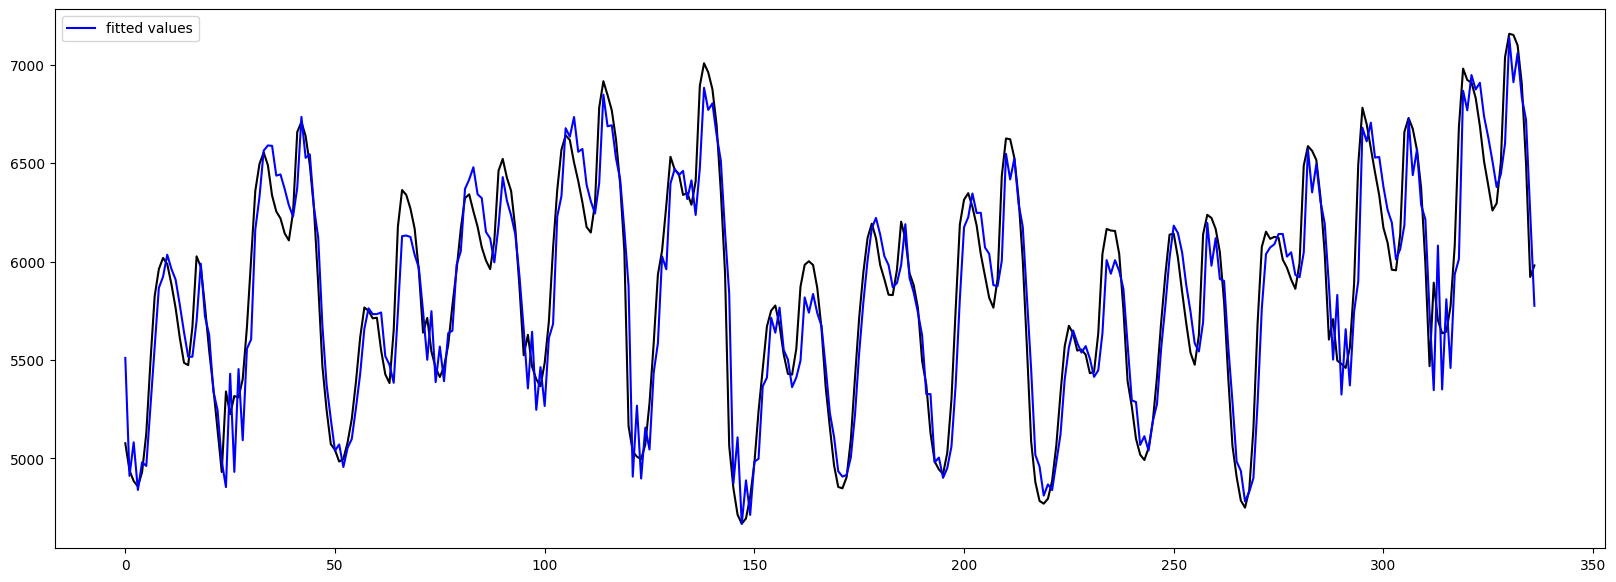

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y, color='black')
plt.plot(np.arange(0, len(y)), fitted_trans, color='blue', label = "fitted values")
#plt.plot(np.arange(0, len(y)), r_fitted_values, color='red', label = "R-fitted values")
plt.legend()

## Number of harmonics in trig models

In [57]:
@njit(nogil=NOGIL, cache=CACHE)
def makeSingleFourier(j,m,T): 
    fourier = np.zeros((T,2))
    for t in range(T): 
        fourier[t,0] = np.cos((2*np.pi*j)/m)
        fourier[t,1] = np.sin((2*np.pi*j)/m) 
    return fourier 

In [58]:
def calcFTest(r_sse, ur_sse, num_restrictions, num_u_params, num_observations):
    num = (r_sse-ur_sse)/num_restrictions 
    den = r_sse/(num_restrictions-num_u_params)
    fstat = num/den 
    p_value = f.cdf(f.stat, num_restrictions, (num_observations-num_u_params))
    return p_value 